# IBM Applied Data Science Capstone
## Identifying the best restaurants in the Greater Cincinnati area

### Part I: Imports

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
from urllib.request import urlopen
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print('Libraries imported.')

Libraries imported.


### Part 2: Foursquare API Setup

In [2]:
# get geographical coordinates for Cincinnati, OH
address = 'Cincinnati, Ohio'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cincinnati are {}, {}.'.format(latitude, longitude))

C:\Users\sanja\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Cincinnati are 39.1014537, -84.5124602.


In [3]:
# set up credentials for Foresquare API
CLIENT_ID = "AREDYM54BSAGERQHZPPGRIF5LZPJTEF3PFLHATZT0JGBZENH"
CLIENT_SECRET = "SPZANWWMIEFCFOMTERDR2OHFFHK2PEAJVCP02QLMXQ3P50QG"
VERSION = '20200508'

In [4]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AREDYM54BSAGERQHZPPGRIF5LZPJTEF3PFLHATZT0JGBZENH&client_secret=SPZANWWMIEFCFOMTERDR2OHFFHK2PEAJVCP02QLMXQ3P50QG&v=20200508&ll=39.1014537,-84.5124602&radius=1000&limit=100'

### Part 3: Initial Data Collection

In [5]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb6f0eb60ba08001bf535df'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Central Business District',
  'headerFullLocation': 'Central Business District, Cincinnati',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 164,
  'suggestedBounds': {'ne': {'lat': 39.11045370900001,
    'lng': -84.50088435852419},
   'sw': {'lat': 39.09245369099999, 'lng': -84.52403604147582}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5154c81ae4b0c54802cba3c7',
       'name': 'Sotto',
       'location': {'address': '114 E 6th St',
        'crossStreet': 'Walnut',
        'lat': 39.102797145086065,
        

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
# pull data from the Foursquare API
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis = 1)
nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Sotto,5154c81ae4b0c54802cba3c7,Italian Restaurant,39.102797,-84.511263
1,21c Museum Hotels - Cincinnati,4f1825f8e4b0b4cc23ba433b,Hotel,39.103165,-84.512087
2,Boca,5185a0d0498e2061f617db14,Restaurant,39.102785,-84.511302
3,Aronoff Center for the Arts,4b4607f3f964a520871426e3,Performing Arts Venue,39.103560,-84.511932
4,Sleepy Bee Cafe,5a6dea8297cf5a7b38b5e293,Café,39.100055,-84.512272
5,Contemporary Arts Center,4b48bd02f964a520d65426e3,Art Museum,39.102685,-84.511811
6,Orchids at Palm Court,4b1478a3f964a5208ba323e3,New American Restaurant,39.100626,-84.514335
7,Fountain Square,4b438206f964a520fbe125e3,Plaza,39.101448,-84.512519
8,Aster On Fourth,5a4e9cc26bd36b1ecb142000,Cocktail Bar,39.100030,-84.512254
9,Graeter's Ice Cream,4b4f5355f964a520680127e3,Ice Cream Shop,39.101487,-84.511860


In [8]:
#fix the column names
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,id,categories,lat,lng
0,Sotto,5154c81ae4b0c54802cba3c7,Italian Restaurant,39.102797,-84.511263
1,21c Museum Hotels - Cincinnati,4f1825f8e4b0b4cc23ba433b,Hotel,39.103165,-84.512087
2,Boca,5185a0d0498e2061f617db14,Restaurant,39.102785,-84.511302
3,Aronoff Center for the Arts,4b4607f3f964a520871426e3,Performing Arts Venue,39.103560,-84.511932
4,Sleepy Bee Cafe,5a6dea8297cf5a7b38b5e293,Café,39.100055,-84.512272
5,Contemporary Arts Center,4b48bd02f964a520d65426e3,Art Museum,39.102685,-84.511811
6,Orchids at Palm Court,4b1478a3f964a5208ba323e3,New American Restaurant,39.100626,-84.514335
7,Fountain Square,4b438206f964a520fbe125e3,Plaza,39.101448,-84.512519
8,Aster On Fourth,5a4e9cc26bd36b1ecb142000,Cocktail Bar,39.100030,-84.512254
9,Graeter's Ice Cream,4b4f5355f964a520680127e3,Ice Cream Shop,39.101487,-84.511860


In [9]:
# find a list of unique categories from the API
nearby_venues['categories'].unique()

array(['Italian Restaurant', 'Hotel', 'Restaurant',
       'Performing Arts Venue', 'Café', 'Art Museum',
       'New American Restaurant', 'Plaza', 'Cocktail Bar',
       'Ice Cream Shop', 'Mexican Restaurant', 'Breakfast Spot',
       'Cupcake Shop', 'Sushi Restaurant', 'Latin American Restaurant',
       'Juice Bar', 'Smoke Shop', 'Scenic Lookout', 'Steakhouse',
       'Burger Joint', 'Fast Food Restaurant', 'French Restaurant', 'Bar',
       'Bistro', 'Department Store', 'History Museum', 'Sandwich Place',
       'Pizza Place', 'Lounge', 'Museum', 'Coffee Shop',
       'Vietnamese Restaurant', 'Nightclub', 'Baseball Stadium',
       'American Restaurant', 'Japanese Restaurant', 'Park', 'Gastropub',
       'Gym', 'Speakeasy', 'Football Stadium', 'Deli / Bodega',
       'Theme Park Ride / Attraction', 'Butcher', 'Indie Theater',
       'Cuban Restaurant', 'Gay Bar', 'Taco Place', 'Bakery',
       'Supplement Shop', 'Beer Garden', 'Bookstore', 'Sports Bar',
       'Tapas Restaurant', 

In [10]:
# create a list of categories to remove from the dataframe because they are not restaurants
removal_list = ['Hotel', 'Performing Arts Venue', 'Art Museum', 'Plaza', 'Smoke Shop', 'Scenic Lookout','Department Store',
                'History Museum', 'Lounge', 'Museum', 'Nightclub', 'Baseball Stadium', 'Park', 'Gym', 'Speakeasy',
                'Football Stadium', 'Theme Park Ride / Attraction', 'Butcher', 'Indie Theater', 'Gay Bar', 
                'Supplement Shop', 'Beer Garden', 'Bookstore', 'Grocery Store', 'Theater']

# construct dataframe of just restaurants 
final_venues = nearby_venues.copy()
final_venues = final_venues[~final_venues['categories'].isin(removal_list)]
final_venues.reset_index(drop = True, inplace = True)
final_venues

,name,id,categories,lat,lng
0,Sotto,5154c81ae4b0c54802cba3c7,Italian Restaurant,39.102797,-84.511263
1,Boca,5185a0d0498e2061f617db14,Restaurant,39.102785,-84.511302
2,Sleepy Bee Cafe,5a6dea8297cf5a7b38b5e293,Café,39.100055,-84.512272
3,Orchids at Palm Court,4b1478a3f964a5208ba323e3,New American Restaurant,39.100626,-84.514335
4,Aster On Fourth,5a4e9cc26bd36b1ecb142000,Cocktail Bar,39.100030,-84.512254
5,Graeter's Ice Cream,4b4f5355f964a520680127e3,Ice Cream Shop,39.101487,-84.511860
6,Nada,4b317901f964a520910725e3,Mexican Restaurant,39.102941,-84.511680
7,Maplewood Kitchen and Bar,57680d90498e9e7e4183734a,Breakfast Spot,39.101513,-84.515113
8,Abby Girl Sweets,4b4b728ff964a520059c26e3,Cupcake Shop,39.101057,-84.514314
9,FUSIAN,4bed7a8091380f47c9f09f18,Sushi Restaurant,39.102720,-84.512924


### Part 4: Advanced Data Collection

In [11]:
# create a list of venue IDs
venue_ids = final_venues['id'].tolist()
venue_ids

['5154c81ae4b0c54802cba3c7',
 '5185a0d0498e2061f617db14',
 '5a6dea8297cf5a7b38b5e293',
 '4b1478a3f964a5208ba323e3',
 '5a4e9cc26bd36b1ecb142000',
 '4b4f5355f964a520680127e3',
 '4b317901f964a520910725e3',
 '57680d90498e9e7e4183734a',
 '4b4b728ff964a520059c26e3',
 '4bed7a8091380f47c9f09f18',
 '50980e2bd63eb33c0a84d7f4',
 '55cd2670498e0624984040e8',
 '4b7d68a2f964a520cdbc2fe3',
 '4b44357ef964a520b5f225e3',
 '4b92ff3af964a520842d34e3',
 '56605066498e467affa580ef',
 '5bc8c19ce0c0c9002c9c5aeb',
 '4ba8cd26f964a52007f039e3',
 '4b17fd3af964a520f1ca23e3',
 '4c620363e1621b8d79a72253',
 '4b3d1320f964a520588d25e3',
 '57f69a75498ee867debabeb9',
 '4b47f539f964a5201b4526e3',
 '4f5fd1b9e4b0005742f4f53e',
 '585a9629cf44517dc01928d3',
 '55f31264498ebc576e3e6bee',
 '4feb428aebcabf0f092bfe57',
 '5a6a03209e3b651f15217a6b',
 '514b70e8e88971e7503c73b1',
 '4b4e4102f964a520f7e626e3',
 '4b460755f964a5207d1426e3',
 '53760551498e68b83d4e746c',
 '4cf7b1015c0e6a31b4b74099',
 '4b9a70f9f964a5208cb535e3',
 '4bc5e8b3f360

In [12]:
# get likes from Foursquare API based on venue ID
url_list = []
likes_list = []
json_list = []

for i in venue_ids:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    likes_list.append(likes)
print(likes_list)

[205, 95, 23, 61, 16, 119, 358, 98, 16, 66, 85, 39, 14, 83, 80, 53, 0, 9, 35, 32, 140, 51, 90, 18, 29, 8, 25, 14, 348, 55, 281, 91, 92, 18, 509, 18, 315, 37, 83, 22, 55, 13, 65, 69, 177, 9, 297, 103, 21, 31, 160, 26, 68, 16, 6, 10, 84, 41, 101, 18, 123, 74, 12, 7]


In [13]:
# create of a copy of the restaurant dataframe
cincy_venues = final_venues.copy()
cincy_venues

,name,id,categories,lat,lng
0,Sotto,5154c81ae4b0c54802cba3c7,Italian Restaurant,39.102797,-84.511263
1,Boca,5185a0d0498e2061f617db14,Restaurant,39.102785,-84.511302
2,Sleepy Bee Cafe,5a6dea8297cf5a7b38b5e293,Café,39.100055,-84.512272
3,Orchids at Palm Court,4b1478a3f964a5208ba323e3,New American Restaurant,39.100626,-84.514335
4,Aster On Fourth,5a4e9cc26bd36b1ecb142000,Cocktail Bar,39.100030,-84.512254
5,Graeter's Ice Cream,4b4f5355f964a520680127e3,Ice Cream Shop,39.101487,-84.511860
6,Nada,4b317901f964a520910725e3,Mexican Restaurant,39.102941,-84.511680
7,Maplewood Kitchen and Bar,57680d90498e9e7e4183734a,Breakfast Spot,39.101513,-84.515113
8,Abby Girl Sweets,4b4b728ff964a520059c26e3,Cupcake Shop,39.101057,-84.514314
9,FUSIAN,4bed7a8091380f47c9f09f18,Sushi Restaurant,39.102720,-84.512924


In [14]:
# create column for restaurant likes
cincy_venues["likes"] = likes_list
cincy_venues.head()

,name,id,categories,lat,lng,likes
0,Sotto,5154c81ae4b0c54802cba3c7,Italian Restaurant,39.102797,-84.511263,205
1,Boca,5185a0d0498e2061f617db14,Restaurant,39.102785,-84.511302,95
2,Sleepy Bee Cafe,5a6dea8297cf5a7b38b5e293,Café,39.100055,-84.512272,23
3,Orchids at Palm Court,4b1478a3f964a5208ba323e3,New American Restaurant,39.100626,-84.514335,61
4,Aster On Fourth,5a4e9cc26bd36b1ecb142000,Cocktail Bar,39.100030,-84.512254,16


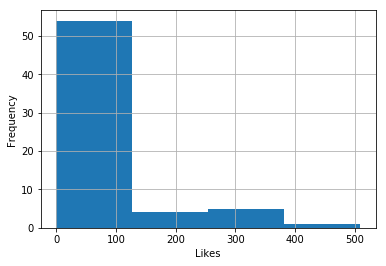

In [15]:
# visualize likes in a histogram
cincy_venues['likes'].hist(bins = 4)
plt.ylabel("Frequency")
plt.xlabel("Likes")
plt.show()

In [16]:
# identify bin edges
print(np.percentile(cincy_venues["likes"], 25))
print(np.percentile(cincy_venues["likes"], 50))
print(np.percentile(cincy_venues["likes"], 75))

18.0
54.0
92.75


In [17]:
# define rating categories based on bin edges
def likes_conditions(s):
    if s["likes"] <= 18:
        return 'poor'
    if s["likes"] <= 54:
        return 'below avg'
    if s["likes"] <= 92.75:
        return 'above avg'
    if s["likes"] > 92.75:
        return 'great'

# add rating category to main dataframe
cincy_venues['likes category'] = cincy_venues.apply(likes_conditions, axis = 1)
cincy_venues

,name,id,categories,lat,lng,likes,likes category
0,Sotto,5154c81ae4b0c54802cba3c7,Italian Restaurant,39.102797,-84.511263,205,great
1,Boca,5185a0d0498e2061f617db14,Restaurant,39.102785,-84.511302,95,great
2,Sleepy Bee Cafe,5a6dea8297cf5a7b38b5e293,Café,39.100055,-84.512272,23,below avg
3,Orchids at Palm Court,4b1478a3f964a5208ba323e3,New American Restaurant,39.100626,-84.514335,61,above avg
4,Aster On Fourth,5a4e9cc26bd36b1ecb142000,Cocktail Bar,39.100030,-84.512254,16,poor
5,Graeter's Ice Cream,4b4f5355f964a520680127e3,Ice Cream Shop,39.101487,-84.511860,119,great
6,Nada,4b317901f964a520910725e3,Mexican Restaurant,39.102941,-84.511680,358,great
7,Maplewood Kitchen and Bar,57680d90498e9e7e4183734a,Breakfast Spot,39.101513,-84.515113,98,great
8,Abby Girl Sweets,4b4b728ff964a520059c26e3,Cupcake Shop,39.101057,-84.514314,16,poor
9,FUSIAN,4bed7a8091380f47c9f09f18,Sushi Restaurant,39.102720,-84.512924,66,above avg


In [18]:
cincy_venues['categories'].unique()

array(['Italian Restaurant', 'Restaurant', 'Café',
       'New American Restaurant', 'Cocktail Bar', 'Ice Cream Shop',
       'Mexican Restaurant', 'Breakfast Spot', 'Cupcake Shop',
       'Sushi Restaurant', 'Latin American Restaurant', 'Juice Bar',
       'Steakhouse', 'Burger Joint', 'Fast Food Restaurant',
       'French Restaurant', 'Bar', 'Bistro', 'Sandwich Place',
       'Pizza Place', 'Coffee Shop', 'Vietnamese Restaurant',
       'American Restaurant', 'Japanese Restaurant', 'Gastropub',
       'Deli / Bodega', 'Cuban Restaurant', 'Taco Place', 'Bakery',
       'Sports Bar', 'Tapas Restaurant'], dtype=object)

In [19]:
# group venues into various categories
bar = ['Cocktail Bar', 'Bar', 'Gastropub', 'Sports Bar', 'Bistro']
other = ['Ice Cream Shop', 'Breakfast Spot', 'Cupcake Shop', 'Juice Bar', 'Sandwich Place', 'Bakery', 'Coffee Shop', 'Café', 'Restaurant']
asian = ['Sushi Restaurant', 'Japanese Restaurant', 'Vietnamese Restaurant']
hispanic = ['Mexican Restaurant', 'Latin American Restaurant', 'Taco Place', 'Cuban Restaurant', 'Tapas Restaurant']
american = ['New American Restaurant', 'Steakhouse', 'Burger Joint', 'Fast Food Restaurant', 'American Restaurant']
european = ['Italian Restaurant', 'Pizza Place', 'Deli / Bodega', 'French Restaurant']

def category_conditions(s):
    if s['categories'] in bar:
        return 'bar'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in asian:
        return 'asian'
    if s['categories'] in hispanic:
        return 'hispanic'
    if s['categories'] in american:
        return 'american'
    if s['categories'] in european:
        return 'european'

# add categories into main dataframe
cincy_venues['food type'] = cincy_venues.apply(category_conditions, axis = 1)
cincy_venues

,name,id,categories,lat,lng,likes,likes category,food type
0,Sotto,5154c81ae4b0c54802cba3c7,Italian Restaurant,39.102797,-84.511263,205,great,european
1,Boca,5185a0d0498e2061f617db14,Restaurant,39.102785,-84.511302,95,great,other
2,Sleepy Bee Cafe,5a6dea8297cf5a7b38b5e293,Café,39.100055,-84.512272,23,below avg,other
3,Orchids at Palm Court,4b1478a3f964a5208ba323e3,New American Restaurant,39.100626,-84.514335,61,above avg,american
4,Aster On Fourth,5a4e9cc26bd36b1ecb142000,Cocktail Bar,39.100030,-84.512254,16,poor,bar
5,Graeter's Ice Cream,4b4f5355f964a520680127e3,Ice Cream Shop,39.101487,-84.511860,119,great,other
6,Nada,4b317901f964a520910725e3,Mexican Restaurant,39.102941,-84.511680,358,great,hispanic
7,Maplewood Kitchen and Bar,57680d90498e9e7e4183734a,Breakfast Spot,39.101513,-84.515113,98,great,other
8,Abby Girl Sweets,4b4b728ff964a520059c26e3,Cupcake Shop,39.101057,-84.514314,16,poor,other
9,FUSIAN,4bed7a8091380f47c9f09f18,Sushi Restaurant,39.102720,-84.512924,66,above avg,asian


### Part 5: Clustering

In [20]:
# one hot encoding
cincy_onehot = pd.get_dummies(cincy_venues[['likes category', 'food type']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
cincy_onehot['name'] = cincy_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [cincy_onehot.columns[-1]] + list(cincy_onehot.columns[:-1])
cincy_onehot = cincy_onehot[fixed_columns]

cincy_onehot.head()

,name,above avg,below avg,great,poor,american,asian,bar,european,hispanic,other
0,Sotto,0,0,1,0,0,0,0,1,0,0
1,Boca,0,0,1,0,0,0,0,0,0,1
2,Sleepy Bee Cafe,0,1,0,0,0,0,0,0,0,1
3,Orchids at Palm Court,1,0,0,0,1,0,0,0,0,0
4,Aster On Fourth,0,0,0,1,0,0,1,0,0,0


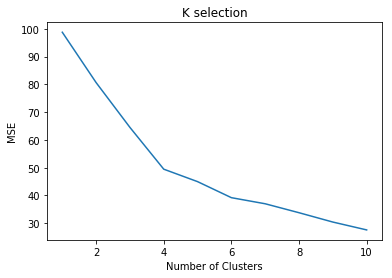

In [21]:
# finding best k to use
Ks = 11
mse = np.zeros((Ks - 1))
cluster_df = cincy_onehot.drop('name', axis = 1)
for n in range(1, Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(cluster_df)
    mse[n - 1] = kmeans.inertia_

plt.plot(range(1,Ks), mse)
plt.xlabel("Number of Clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [22]:
# run k-means clustering
k_clusters = 6
kmeans = KMeans(n_clusters = k_clusters, random_state = 0).fit(cluster_df)
kmeans.labels_[0:10]

array([1, 5, 0, 3, 2, 5, 1, 5, 4, 3])

In [23]:
# add cluster labels to main dataframe
cincy_venues['cluster'] = kmeans.labels_
cincy_venues

,name,id,categories,lat,lng,likes,likes category,food type,cluster
0,Sotto,5154c81ae4b0c54802cba3c7,Italian Restaurant,39.102797,-84.511263,205,great,european,1
1,Boca,5185a0d0498e2061f617db14,Restaurant,39.102785,-84.511302,95,great,other,5
2,Sleepy Bee Cafe,5a6dea8297cf5a7b38b5e293,Café,39.100055,-84.512272,23,below avg,other,0
3,Orchids at Palm Court,4b1478a3f964a5208ba323e3,New American Restaurant,39.100626,-84.514335,61,above avg,american,3
4,Aster On Fourth,5a4e9cc26bd36b1ecb142000,Cocktail Bar,39.100030,-84.512254,16,poor,bar,2
5,Graeter's Ice Cream,4b4f5355f964a520680127e3,Ice Cream Shop,39.101487,-84.511860,119,great,other,5
6,Nada,4b317901f964a520910725e3,Mexican Restaurant,39.102941,-84.511680,358,great,hispanic,1
7,Maplewood Kitchen and Bar,57680d90498e9e7e4183734a,Breakfast Spot,39.101513,-84.515113,98,great,other,5
8,Abby Girl Sweets,4b4b728ff964a520059c26e3,Cupcake Shop,39.101057,-84.514314,16,poor,other,4
9,FUSIAN,4bed7a8091380f47c9f09f18,Sushi Restaurant,39.102720,-84.512924,66,above avg,asian,3


### Part 6: Data Visualization

In [24]:
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 15)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i * x) ** 2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cincy_venues['lat'], cincy_venues['lng'], cincy_venues['name'], cincy_venues['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

In [25]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # add dridlines based on minor ticks
    ax.grid(which = 'minor', color = 'w', linestyle = '-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    #print(values_cumsum)

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        #color_val = colormap((float(values_cumsum[i])/total_values))
        color_val = colormap(np.linspace(0,1,6)[i])
        #print(np.arange(1,6)[i]/5)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles = legend_handles,
        loc = 'lower center', 
        ncol = len(categories),
        bbox_to_anchor = (0., -0.2, 0.95, .1)
    )

Total number of tiles is 400
Cluster I: 88
Cluster II: 69
Cluster III: 62
Cluster IV: 100
Cluster V: 50
Cluster VI: 31


<Figure size 432x288 with 0 Axes>

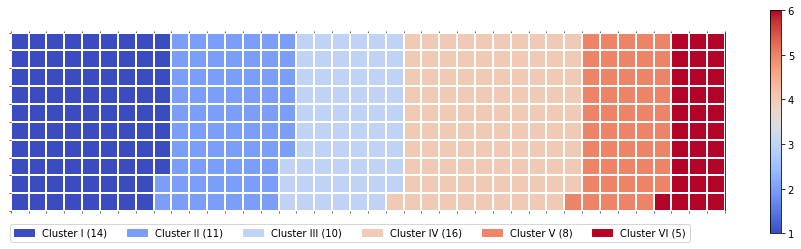

In [26]:
# create waffle chart
cl1 = cincy_venues.loc[cincy_venues['cluster'] == 0, cincy_venues.columns[[1] + list(range(6, cincy_venues.shape[1]))]]
cl2 = cincy_venues.loc[cincy_venues['cluster'] == 1, cincy_venues.columns[[1] + list(range(6, cincy_venues.shape[1]))]]
cl3 = cincy_venues.loc[cincy_venues['cluster'] == 2, cincy_venues.columns[[1] + list(range(6, cincy_venues.shape[1]))]]
cl4 = cincy_venues.loc[cincy_venues['cluster'] == 3, cincy_venues.columns[[1] + list(range(6, cincy_venues.shape[1]))]]
cl5 = cincy_venues.loc[cincy_venues['cluster'] == 4, cincy_venues.columns[[1] + list(range(6, cincy_venues.shape[1]))]]
cl6 = cincy_venues.loc[cincy_venues['cluster'] == 5, cincy_venues.columns[[1] + list(range(6, cincy_venues.shape[1]))]]
index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV', 'Cluster V', 'Cluster VI']
portions = [cl1.shape[0], cl2.shape[0], cl3.shape[0], cl4.shape[0], cl5.shape[0], cl6.shape[0]]
width = 40 # width of chart
height = 10 # height of chart
categories = index # categories
values = portions # correponding values of categories
colormap = plt.cm.coolwarm # color map class
create_waffle_chart(categories, values, height, width, colormap)

### Part 7: Cluster Separation

In [27]:
# see which restaurants are in cluster 0
cincy_venues.loc[cincy_venues['cluster'] == 0]

,name,id,categories,lat,lng,likes,likes category,food type,cluster
2,Sleepy Bee Cafe,5a6dea8297cf5a7b38b5e293,Café,39.100055,-84.512272,23,below avg,other,0
11,Mita's,55cd2670498e0624984040e8,Latin American Restaurant,39.101161,-84.514726,39,below avg,hispanic,0
15,Bru Burger Bar,56605066498e467affa580ef,Burger Joint,39.102452,-84.511868,53,below avg,american,0
18,Morton's The Steakhouse,4b17fd3af964a520f1ca23e3,Steakhouse,39.100958,-84.513089,35,below avg,american,0
19,Jean-Robert's Table,4c620363e1621b8d79a72253,French Restaurant,39.104101,-84.513649,32,below avg,european,0
21,Taste of Belgium - The Banks,57f69a75498ee867debabeb9,Bistro,39.096929,-84.512024,51,below avg,bar,0
24,Pies & Pints,585a9629cf44517dc01928d3,Pizza Place,39.096872,-84.513252,29,below avg,european,0
26,Le's Pho and Sandwiches,4feb428aebcabf0f092bfe57,Vietnamese Restaurant,39.106369,-84.514132,25,below avg,asian,0
37,Ruth's Chris Steak House,507a2452e4b0ce42c6bdef75,Steakhouse,39.097418,-84.510127,37,below avg,american,0
39,Queen City Exchange,57f8fbf4498ecadc3af56807,Bar,39.106092,-84.515353,22,below avg,bar,0


In [28]:
# see which restaurants are in cluster 1
cincy_venues.loc[cincy_venues['cluster'] == 1]

,name,id,categories,lat,lng,likes,likes category,food type,cluster
0,Sotto,5154c81ae4b0c54802cba3c7,Italian Restaurant,39.102797,-84.511263,205,great,european,1
6,Nada,4b317901f964a520910725e3,Mexican Restaurant,39.102941,-84.511680,358,great,hispanic,1
20,Arnold's Bar & Grill,4b3d1320f964a520588d25e3,Bar,39.104977,-84.510209,140,great,bar,1
28,Yard House,514b70e8e88971e7503c73b1,American Restaurant,39.096804,-84.510510,348,great,american,1
34,Moerlein Lager House,4bc5e8b3f360ef3b98c3da2d,Gastropub,39.096311,-84.508673,509,great,bar,1
36,Taste of Belgium OTR,4e33323afa76f00388beb648,American Restaurant,39.108309,-84.514806,315,great,american,1
44,Senate Restaurant,4b7c72d2f964a5200c942fe3,Gastropub,39.108696,-84.514819,177,great,bar,1
46,Bakersfield,4f2dde37e4b007725af12e10,Taco Place,39.108687,-84.515130,297,great,hispanic,1
50,A Tavola,4da8cef45da3ba8a47624c59,Italian Restaurant,39.108973,-84.514891,160,great,european,1
58,rhinehaus,507ad9a5e4b04c2b97f7a51b,Sports Bar,39.108544,-84.512414,101,great,bar,1


In [29]:
# see which restaurants are in cluster 2
cincy_venues.loc[cincy_venues['cluster'] == 2]

,name,id,categories,lat,lng,likes,likes category,food type,cluster
4,Aster On Fourth,5a4e9cc26bd36b1ecb142000,Cocktail Bar,39.100030,-84.512254,16,poor,bar,2
16,Chick-Fil-A,5bc8c19ce0c0c9002c9c5aeb,Fast Food Restaurant,39.102455,-84.510390,0,poor,american,2
27,Wahlburgers,5a6a03209e3b651f15217a6b,Burger Joint,39.102808,-84.510259,14,poor,american,2
35,Silverglades on 8th,4b7a1290f964a520cb212fe3,Deli / Bodega,39.105252,-84.509121,18,poor,european,2
41,Cuban Pete Sandwiches,5527f715498ea7c14e73bdce,Cuban Restaurant,39.106475,-84.511285,13,poor,hispanic,2
45,Restaurant L,57e1a32e498e8e1645bd1d5e,French Restaurant,39.099618,-84.507433,9,poor,european,2
54,Crown Republic Gastropub,5b2b062c464d65002cc786dd,Gastropub,39.105043,-84.508747,6,poor,bar,2
55,Kitty's Sports Grill,560c708e498e541b90075039,Sports Bar,39.098082,-84.515842,10,poor,bar,2
59,Boomtown Biscuits & Whiskey,59e6b5ac7564f74cb2b6737b,American Restaurant,39.109662,-84.508557,18,poor,american,2
63,The Stretch,5830d14765e7c7635dfebb23,Bar,39.097372,-84.509334,7,poor,bar,2


In [30]:
# see which restaurants are in cluster 3
cincy_venues.loc[cincy_venues['cluster'] == 3]

,name,id,categories,lat,lng,likes,likes category,food type,cluster
3,Orchids at Palm Court,4b1478a3f964a5208ba323e3,New American Restaurant,39.100626,-84.514335,61,above avg,american,3
9,FUSIAN,4bed7a8091380f47c9f09f18,Sushi Restaurant,39.102720,-84.512924,66,above avg,asian,3
10,Metropole,50980e2bd63eb33c0a84d7f4,Restaurant,39.103174,-84.511813,85,above avg,other,3
13,Via Vite,4b44357ef964a520b5f225e3,Italian Restaurant,39.101519,-84.512572,83,above avg,european,3
14,Jeff Ruby's Steakhouse,4b92ff3af964a520842d34e3,Steakhouse,39.103869,-84.511959,80,above avg,american,3
22,Knockback Nat's,4b47f539f964a5201b4526e3,Bar,39.103713,-84.513886,90,above avg,bar,3
29,Mr. Sushi,4b4e4102f964a520f7e626e3,Japanese Restaurant,39.102716,-84.511143,55,above avg,asian,3
31,Cheapside Cafe,53760551498e68b83d4e746c,Café,39.105442,-84.507739,91,above avg,other,3
32,Tom & Chee,4cf7b1015c0e6a31b4b74099,Sandwich Place,39.106820,-84.511710,92,above avg,other,3
38,Taqueria Mercado,4bd5f1944e32d13ad0c6c180,Mexican Restaurant,39.104830,-84.512175,83,above avg,hispanic,3


In [31]:
# see which restaurants are in cluster 4
cincy_venues.loc[cincy_venues['cluster'] == 4]

,name,id,categories,lat,lng,likes,likes category,food type,cluster
8,Abby Girl Sweets,4b4b728ff964a520059c26e3,Cupcake Shop,39.101057,-84.514314,16,poor,other,4
12,Total Juice Plus,4b7d68a2f964a520cdbc2fe3,Juice Bar,39.103375,-84.513543,14,poor,other,4
17,Cafe De Paris,4ba8cd26f964a52007f039e3,Café,39.104384,-84.514501,9,poor,other,4
23,Silver Ladle,4f5fd1b9e4b0005742f4f53e,Sandwich Place,39.102741,-84.510546,18,poor,other,4
25,Lola's,55f31264498ebc576e3e6bee,Coffee Shop,39.098720,-84.513461,8,poor,other,4
33,Izzy's,4b9a70f9f964a5208cb535e3,Sandwich Place,39.103291,-84.510168,18,poor,other,4
53,Brown Bear Bakery,515d1365e4b0d2cd6d15e8e6,Bakery,39.109888,-84.512572,16,poor,other,4
62,SugarSnap!,502fcd7ce4b04de6f3c87eb2,Cupcake Shop,39.109456,-84.512902,12,poor,other,4


In [32]:
# see which restaurants are in cluster 5
cincy_venues.loc[cincy_venues['cluster'] == 5]

,name,id,categories,lat,lng,likes,likes category,food type,cluster
1,Boca,5185a0d0498e2061f617db14,Restaurant,39.102785,-84.511302,95,great,other,5
5,Graeter's Ice Cream,4b4f5355f964a520680127e3,Ice Cream Shop,39.101487,-84.511860,119,great,other,5
7,Maplewood Kitchen and Bar,57680d90498e9e7e4183734a,Breakfast Spot,39.101513,-84.515113,98,great,other,5
30,Coffee Emporium,4b460755f964a5207d1426e3,Coffee Shop,39.107498,-84.512390,281,great,other,5
47,1215 Wine Bar & Coffee Lab,4f349e4ee4b0debe1e46886a,Coffee Shop,39.108851,-84.515014,103,great,other,5
